# Geometric phase metasurface

Metasurface design using the geometric phase (PB phase).

## 0. Prepare

In [1]:
import importlib.util
# import lumapi
spec = importlib.util.spec_from_file_location('lumapi', 'D:\\Program Files\\Lumerical\\v241\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)

In [2]:
import time
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import klayout.db as db  # use klayout package to generate GDS file

In [3]:
# import custom modules
sys.path.append("../module")
from MetaTool import nk2permittivity, setResources, getMatrixCenter

## 1. Constants, classes and functions

In [4]:
# colorbar setting
cmap_amp = "Reds"  # amplitude use
cmap_ang = "RdBu_r"  # angle (phase) use

## 2. Meta-atom design

Design the meta-atom and optimize the structure parameters to obtain best transmittance and polarization conversion efficiency (PCE).

We use the rectangle meta-atom as an example.

Here the incident light is RCP and the target output light is LCP. 

### 2.1 Params

In [5]:
# parameters
# control parameters
hide = False  # whether to hide GUI or not

# spectral
wavelength_number = 1  # the number of discretion points of the spectral
wavelength = 633e-9  # [m]
wavelength_min = wavelength
wavelength_max = wavelength

# meta-atom
unit_size = 300e-9  # unit size [m]
offset_x = 1 / 2 * unit_size - unit_size / 2  # the offset of unit in the x direction relative to the center
offset_y = 1 / 2 * unit_size - unit_size / 2  # the offset of unit in the y direction relative to the center

# simulation objects
material_substrate = "Al2O3 - Palik"
material_atom = "TiO2"

separation = wavelength_max / 2  # safe spacing between the objects and simulation boundaries
sep_ub_t = separation  # spacing between upper bound and transmission plane
sep_t_atom = separation  # spacing between transmission plane and atom
sep_interface_source = separation * 0.5  # spacing between interface (atom / substrate) and source
sep_source_lb = separation * 0.5  # spacing between source and lower bound
height_atom = 500e-9  # [m]
height_substrate = separation * 2  # [m]

# simulation size
sim_x_span = unit_size
sim_y_span = unit_size
sim_z_span = sep_ub_t + sep_t_atom + height_atom + sep_interface_source + sep_source_lb

# boundary conditions: PML / Period / Bloch / (Anti-)Symmetric
boundary_x_min = "Period"
boundary_x_max = "Period"
boundary_y_min = "Period"
boundary_y_max = "Period"
boundary_z_min = "PML"
boundary_z_max = "PML"

# mesh settings (automate mesh)
mesh_accuracy = 2

# atom structure (initial parameters)
length_atom = 270e-9  # the length of atom [m]
width_atom = 150e-9  # the width of atom [m]   
rotation_angle_atom = np.deg2rad(0)  # rotation angle of atom [rad]

### 2.2 Optimize meta-atom parameters

#### 2.2.1 Simulation prepare

In [6]:
# open fdtd
fdtd = lumapi.FDTD(hide=hide)
print(">> Progress: FDTD is opened.")

>> Progress: FDTD is opened.


In [7]:
# add material
material_name = "TiO2"
material_df = pd.read_csv("../material/TiO2.csv")
material_np = np.array(material_df)
# obtain the frequency array
wavelength_array = material_np[:, 0] * 1e-6  # [m]
frequency_array = fdtd.c() / wavelength_array
# obtain the complex permittivity array from (n, k)
permittivity_array = nk2permittivity(material_np[:, 1], material_np[:, 2])
# combine
sampled_data = np.vstack((frequency_array, permittivity_array)).T
# add
temp = fdtd.addmaterial("Sampled data")
fdtd.setmaterial(temp, "name", material_name)  # rename the material
fdtd.setmaterial(material_name, "max coefficients", 6)  # set the number of coefficients
fdtd.setmaterial(material_name, "color", np.array([255 / 255, 69 / 255, 0 / 255, 1]))
fdtd.setmaterial(material_name, "sampled data", sampled_data)
print(">> Progress: Adding material " + material_name + " is done.")

>> Progress: Adding material TiO2 is done.


In [8]:
# resource settings 
parallel_job_number = 7
processes = 1
threads = 1
capacity = 1
job_launching_preset = "Remote: Intel MPI"  # "Remote: Microsoft MPI" / "Remote: Intel MPI"

setResources(fdtd, parallel_job_number=parallel_job_number, processes=processes, \
    threads=threads, capacity=capacity, job_launching_preset=job_launching_preset)

In [9]:
# define basic objects
# make sure in layout mode
if fdtd.layoutmode() != 1:  # layoutmode() return 0 when in analysis mode
    fdtd.switchtolayout()

fdtd.deleteall()  # clear objects

# source RCP
source_x = fdtd.addplane(
    name="source x",
    # size
    x=0,
    x_span=sim_x_span,
    y=0,
    y_span=sim_y_span,
    z=-sep_interface_source,
    # propagation direction
    injection_axis="z",
    direction="forward",
    angle_theta=0,
    angle_phi=0,
    amplitude=1,
    # polarization direction
    polarization_angle=0,
    # phase
    phase=0,
    # bandwidth
    wavelength_start=wavelength_min,
    wavelength_stop=wavelength_max,
)
source_y = fdtd.addplane(
    name="source y",
    # size
    x=0,
    x_span=sim_x_span,
    y=0,
    y_span=sim_y_span,
    z=-sep_interface_source,
    # propagation direction
    injection_axis="z",
    direction="forward",
    angle_theta=0,
    angle_phi=0,
    amplitude=1,
    # polarization direction
    polarization_angle=90,
    # phase
    phase=90,
    # bandwidth
    wavelength_start=wavelength_min,
    wavelength_stop=wavelength_max,
)

# FDTD
sim_region = fdtd.addfdtd(
    dimension="3D",
    x=0.0,
    x_span=sim_x_span,
    y=0.0,
    y_span=sim_y_span,
    z_min=-(sep_interface_source + sep_source_lb),
    z_max=height_atom + sep_t_atom + sep_ub_t,
    # boundary condition
    x_min_bc=boundary_x_min,
    x_max_bc=boundary_x_max,
    y_min_bc=boundary_y_min,
    y_max_bc=boundary_y_max,
    z_min_bc=boundary_z_min,
    z_max_bc=boundary_z_max,
    pml_layers=8,
    auto_shutoff_min=1e-5,
    mesh_accuracy=mesh_accuracy,
)

# monitor
fdtd.setglobalmonitor("frequency points", wavelength_number)  # global settings
power_profile_t = fdtd.addpower(
    name="power profile T",
    monitor_type="2D Z-normal",
    x=0.0,
    x_span=sim_x_span,
    y=0.0,
    y_span=sim_y_span,
    z=height_atom + sep_t_atom,
)

# structure
substrate = fdtd.addrect(
    name="substrate",
    x=0.0, 
    y=0.0,
    x_span=sim_x_span,
    y_span=sim_y_span,
    z_max=0,
    z_min=-height_substrate,
    material=material_substrate
)
# meta-atom
atom = fdtd.addrect(
    name="atom",
    x=0 * unit_size - offset_x,
    y=0 * unit_size - offset_y,
    x_span=length_atom,
    y_span=width_atom,
    z_min=0,
    z_max=height_atom,
    material=material_atom,
    first_axis="z",
    rotation_1=np.rad2deg(rotation_angle_atom)
)

#### 2.2.2 Iteration optimization

In [10]:
# set the iteration range of the values of length and width of meta-atom
length_vec = np.arange(100e-9, 280e-9, 15e-9)
width_vec = np.arange(100e-9, 280e-9, 15e-9)

# the following variables will be used to store the calculation result
phase_mat = np.zeros((len(length_vec), len(width_vec)))
t_mat = np.zeros((len(length_vec), len(width_vec)))  # transmittance
pce_mat = np.zeros((len(length_vec), len(width_vec)))  # polarization conversion efficiency
pce_t_mat = np.zeros((len(length_vec), len(width_vec)))  # PCE * t

In [11]:
# iterate to find best params
for i in range(len(length_vec)):
    print(">> Progress: {} / {}".format(i * len(length_vec), len(length_vec) * len(width_vec)))
    for j in range(len(width_vec)):
        # switch layout
        if fdtd.layoutmode() != 1:
            fdtd.switchtolayout()
        # modify params
        atom.x_span = length_vec[i]
        atom.y_span = width_vec[j]
        file_name = "../fsp/geometric_atom_" + str(j) + ".fsp"
        fdtd.save(file_name)
        fdtd.addjob(file_name)
        
    fdtd.runjobs()  # run

    for j in range(len(width_vec)):
        file_name = "../fsp/geometric_atom_" + str(j) + ".fsp"
        fdtd.load(file_name)
        # obtaining field profile
        e_x_mat = fdtd.getdata(power_profile_t.name, 'Ex')[:, :, 0, 0]
        e_y_mat = fdtd.getdata(power_profile_t.name, 'Ey')[:, :, 0, 0]
        e_z_mat = fdtd.getdata(power_profile_t.name, 'Ez')[:, :, 0, 0]
        t = fdtd.getresult(power_profile_t.name, 'T')['T'][0]
        # construct circular polarization result with x-polarization and y-polarization results
        e_rcp_mat = (e_x_mat - 1j * e_y_mat) / np.sqrt(2)  # RCP
        e_lcp_mat = (e_x_mat + 1j * e_y_mat) / np.sqrt(2)  # LCP
        # phase
        phase_lcp = getMatrixCenter(np.angle(e_lcp_mat))
        # conversion efficiency (RCP -> LCP)
        pce = np.sum(np.abs(e_lcp_mat ** 2)) / \
            (np.sum(np.abs(e_lcp_mat) ** 2) + np.sum(np.abs(e_rcp_mat ** 2)))
        phase_mat[i, j] = phase_lcp
        t_mat[i, j] = t
        pce_mat[i, j] = pce
        pce_t_mat[i, j] = pce * t

>> Progress: 0 / 169
>> Progress: 13 / 169
>> Progress: 26 / 169
>> Progress: 39 / 169
>> Progress: 52 / 169
>> Progress: 65 / 169
>> Progress: 78 / 169
>> Progress: 91 / 169
>> Progress: 104 / 169
>> Progress: 117 / 169
>> Progress: 130 / 169
>> Progress: 143 / 169
>> Progress: 156 / 169


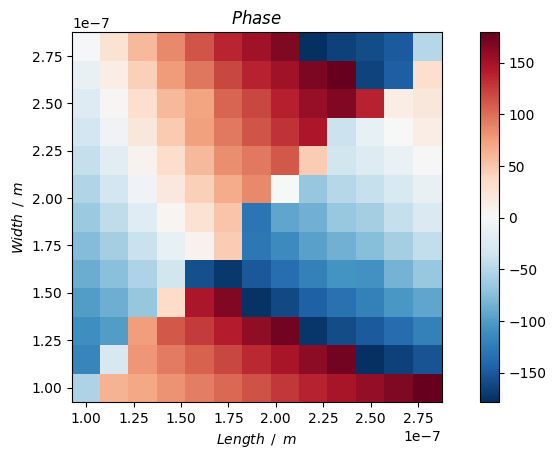

In [12]:
# phase distribution
fig = plt.figure()
c = plt.pcolor(
    length_vec, width_vec, 
    np.rad2deg(phase_mat).T, 
    cmap=cmap_ang
)
fig.colorbar(c)
plt.xlabel(r"$Length \enspace / \enspace m$")
plt.ylabel(r"$Width \enspace / \enspace m$")
plt.title(r"$Phase$")
plt.axis("scaled")
plt.show()

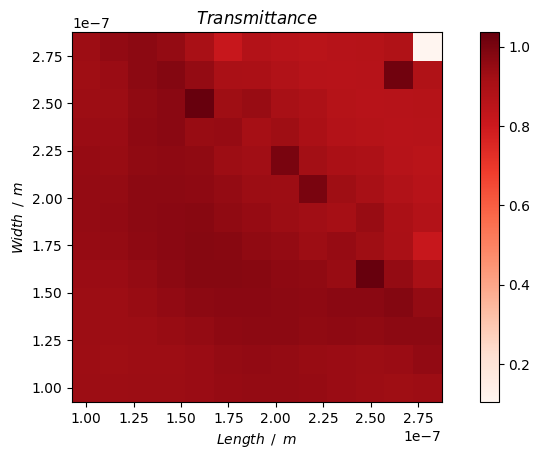

In [13]:
# transmittance distribution
fig = plt.figure()
c = plt.pcolor(
    length_vec, width_vec, 
    t_mat.T, 
    cmap=cmap_amp
)
fig.colorbar(c)
plt.xlabel(r"$Length \enspace / \enspace m$")
plt.ylabel(r"$Width \enspace / \enspace m$")
plt.title(r"$Transmittance$")
plt.axis("scaled")
plt.show()

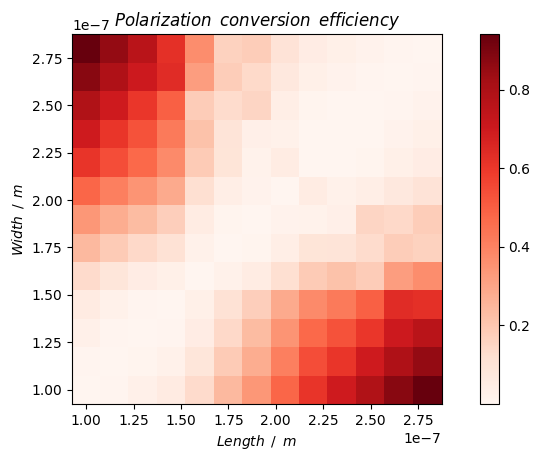

In [14]:
# PCE distribution
fig = plt.figure()
c = plt.pcolor(
    length_vec, width_vec, 
    pce_mat.T, 
    cmap=cmap_amp
)
fig.colorbar(c)
plt.xlabel(r"$Length \enspace / \enspace m$")
plt.ylabel(r"$Width \enspace / \enspace m$")
plt.title(r"$Polarization \enspace conversion \enspace efficiency$")
plt.axis("scaled")
plt.show()

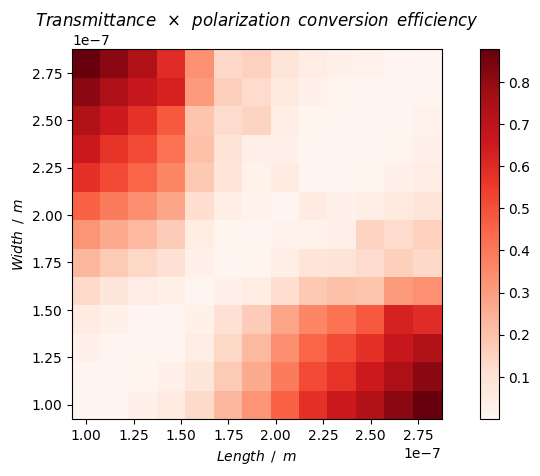

In [15]:
# PCE*transmittance distribution
fig = plt.figure()
c = plt.pcolor(
    length_vec, width_vec, 
    pce_t_mat.T, 
    cmap=cmap_amp
)
fig.colorbar(c)
plt.xlabel(r"$Length \enspace / \enspace m$")
plt.ylabel(r"$Width \enspace / \enspace m$")
plt.title(r"$Transmittance \enspace \times \enspace polarization \enspace conversion \enspace efficiency$")
plt.axis("scaled")
plt.show()

In [16]:
np.where(pce_t_mat == np.max(pce_t_mat))

(array([0], dtype=int64), array([12], dtype=int64))

In [17]:
# find the best meta-atom with the highest PCE*t
length_atom_idx, width_atom_idx = np.where(pce_t_mat == np.max(pce_t_mat))[0][0], np.where(pce_t_mat == np.max(pce_t_mat))[1][0]
length_atom = max(length_vec[length_atom_idx], width_vec[width_atom_idx])
width_atom = min(length_vec[length_atom_idx], width_vec[width_atom_idx])

In [18]:
# print the information of the best meta-atom
print("Optimized meta-atom: length = {:.2f} nm, width = {:.2f} nm".format(length_atom * 1e9, width_atom * 1e9))
print("PCE = {}, t = {}".format(pce_mat[length_atom_idx, width_atom_idx], t_mat[length_atom_idx, width_atom_idx]))

Optimized meta-atom: length = 280.00 nm, width = 100.00 nm
PCE = 0.9416953565823195, t = 0.9329055842245114


## 3. Metasurface design

Design the geometric phase metasurface composed of meta-atoms with different rotation angles.

We use the metasurface hologram as an example.

Optimized parameters `length_atom` and `width_atom` will be used here.

### 3.1 Importing design destination

The hologram phase distribution is obtained by the notebook `ComputerGeneratedHologram.ipynb`.

In [20]:
# import destination phase profile (in space domain) from matlab
phase_profile_dest = np.load("../data/hologram_phase_20_20.npy")
rows, cols = phase_profile_dest.shape  # the row and column number of pattern

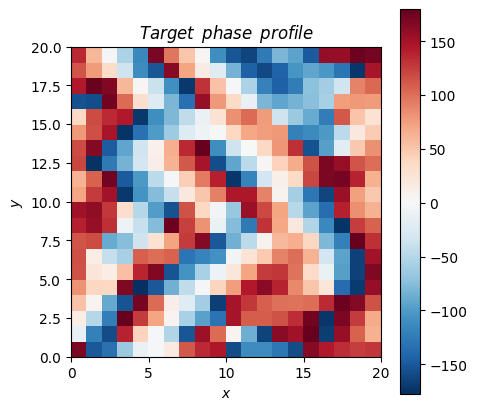

In [21]:
# draw the spatial phase profile
fig = plt.figure(figsize=(5, 5))
c = plt.pcolor(np.rad2deg(phase_profile_dest), cmap=cmap_ang)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("$Target \enspace phase \enspace profile$")
fig.colorbar(c)
plt.gca().set_aspect(1)
plt.show()

### 3.2 Arrangement of rotated meta-atoms

In [22]:
# parameters
units_rows = rows  # the number of rows of metasurface units
units_cols = cols  # the number of columns of metasurface units
offset_x = units_cols / 2 * unit_size - unit_size / 2  # the offset of metasurface in the x direction relative to the center
offset_y = units_rows / 2 * unit_size - unit_size / 2  # the offset of metasurface in the y direction relative to the center

# update simulation size
sim_x_span = unit_size * units_cols
sim_y_span = unit_size * units_rows

# update boundary conditions
boundary_x_min = "PML"
boundary_x_max = "PML"
boundary_y_min = "PML"
boundary_y_max = "PML"
boundary_z_min = "PML"
boundary_z_max = "PML"

In [23]:
# solve the rotation angles of meta-atoms
sigma = -1  # RCP incidence now
units_pos_angle_dict = {}  # dictionary for metasurface units (position and rotation angle)
for i in range(units_rows):
    for j in range(units_cols):
        units_pos_angle_dict[(i, j)] = phase_profile_dest[i, j] / 2 / sigma

### 3.3 Simulation

In [24]:
# resource settings 
parallel_job_number = 1
processes = 6
threads = 1
capacity = 1
job_launching_preset = "Remote: Intel MPI"  # "Remote: Microsoft MPI" / "Remote: Intel MPI"

setResources(fdtd, parallel_job_number=parallel_job_number, processes=processes, \
    threads=threads, capacity=capacity, job_launching_preset=job_launching_preset)

In [25]:
# define basic objects
# make sure in layout mode
if fdtd.layoutmode() != 1:  # layoutmode() return 0 when in analysis mode
    fdtd.switchtolayout()

fdtd.deleteall()  # clear objects

# source RCP
source_x = fdtd.addplane(
    name="source x",
    # size
    x=0,
    x_span=sim_x_span,
    y=0,
    y_span=sim_y_span,
    z=-sep_interface_source,
    # propagation direction
    injection_axis="z",
    direction="forward",
    angle_theta=0,
    angle_phi=0,
    amplitude=1,
    # polarization direction
    polarization_angle=0,
    # phase
    phase=0,
    # bandwidth
    wavelength_start=wavelength_min,
    wavelength_stop=wavelength_max,
)
source_y = fdtd.addplane(
    name="source y",
    # size
    x=0,
    x_span=sim_x_span,
    y=0,
    y_span=sim_y_span,
    z=-sep_interface_source,
    # propagation direction
    injection_axis="z",
    direction="forward",
    angle_theta=0,
    angle_phi=0,
    amplitude=1,
    # polarization direction
    polarization_angle=90,
    # phase
    phase=90,
    # bandwidth
    wavelength_start=wavelength_min,
    wavelength_stop=wavelength_max,
)

# FDTD
sim_region = fdtd.addfdtd(
    dimension="3D",
    x=0.0,
    x_span=sim_x_span,
    y=0.0,
    y_span=sim_y_span,
    z_min=-(sep_interface_source + sep_source_lb),
    z_max=height_atom + sep_t_atom + sep_ub_t,
    # boundary condition
    x_min_bc=boundary_x_min,
    x_max_bc=boundary_x_max,
    y_min_bc=boundary_y_min,
    y_max_bc=boundary_y_max,
    z_min_bc=boundary_z_min,
    z_max_bc=boundary_z_max,
    pml_layers=8,
    auto_shutoff_min=1e-5,
    mesh_accuracy=mesh_accuracy,
)

# monitor
fdtd.setglobalmonitor("frequency points", wavelength_number)  # global settings
power_profile_t = fdtd.addpower(
    name="power profile T",
    monitor_type="2D Z-normal",
    x=0.0,
    x_span=sim_x_span,
    y=0.0,
    y_span=sim_y_span,
    z=height_atom + sep_t_atom,
)

# structure
substrate = fdtd.addrect(
    name="substrate",
    x=0.0, 
    y=0.0,
    x_span=sim_x_span,
    y_span=sim_y_span,
    z_max=0,
    z_min=-height_substrate,
    material=material_substrate
)

# meta-atoms
atoms = []
for pos in units_pos_angle_dict:
    x = pos[1] * unit_size - offset_x
    y = pos[0] * unit_size - offset_y
    atoms.append(fdtd.addrect(
        name="atom_" + str(pos[0]) + "/" + str(pos[1]),
        x=x,
        y=y,
        x_span=length_atom,
        y_span=width_atom,
        z_min=0,
        z_max=height_atom,
        material=material_atom,
        first_axis = 'z',
        rotation_1 = np.rad2deg(units_pos_angle_dict[pos])
    ))

In [26]:
fdtd.save("../fsp/geometric_metasurface.fsp")  # save simulation

In [27]:
t1 = time.perf_counter()  # begin time count
fdtd.run()  # run
t2 = time.perf_counter()  # end time count
print("Run time cost: {}s.".format(t2 - t1))

Run time cost: 63.521262200000024s.


### 3.4 Analysis

Here we just analyze the near field. 

The detailed analysis of metasurface hologram can be found in another notebook `MetasurfaceHologramDesign.ipynb`.

In [28]:
# obtain data
mesh_x_vec = fdtd.getdata(power_profile_t.name, 'x')[:, 0]
mesh_y_vec = fdtd.getdata(power_profile_t.name, 'y')[:, 0]
e_t_x_mat = fdtd.getdata(power_profile_t.name, 'Ex')[:, :, 0, 0]
e_t_y_mat = fdtd.getdata(power_profile_t.name, 'Ey')[:, :, 0, 0]
e_t_z_mat = fdtd.getdata(power_profile_t.name, 'Ez')[:, :, 0, 0]
t = fdtd.getresult(power_profile_t.name, 'T')['T'][0]
# construct circular polarization result with x-polarization and y-polarization results
e_t_rcp_mat = (e_t_x_mat - 1j * e_t_y_mat) / np.sqrt(2)  # RCP
e_t_lcp_mat = (e_t_x_mat + 1j * e_t_y_mat) / np.sqrt(2)  # LCP
# polarization conversion efficiency (RCP -> LCP)
pce = np.sum(np.abs(e_t_lcp_mat ** 2)) / \
    (np.sum(np.abs(e_t_lcp_mat) ** 2) + np.sum(np.abs(e_t_rcp_mat ** 2)))
pce_t = pce * t

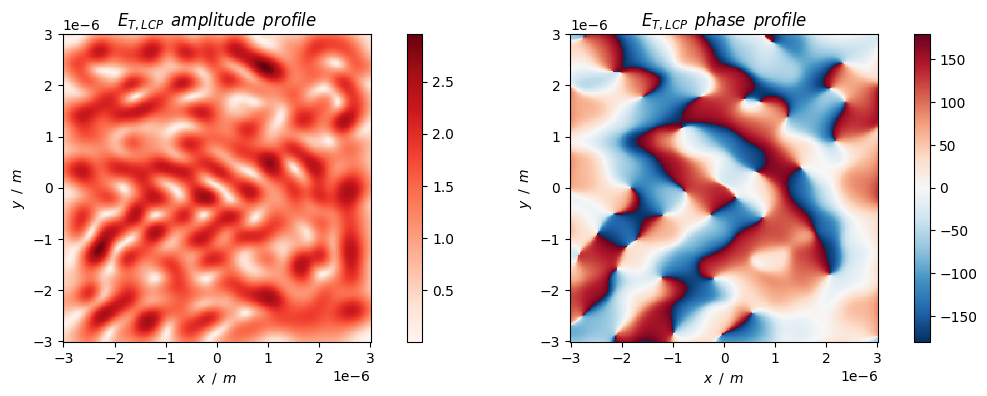

In [29]:
# draw the near field distribution
sep = 1  # sample the dense monitor data

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
c = plt.pcolor(
    mesh_x_vec[::sep],
    mesh_y_vec[::sep],
    np.abs(e_t_lcp_mat[::sep, ::sep]).T, 
    cmap=cmap_amp
)
fig.colorbar(c)
plt.xlabel(r"$x \enspace / \enspace m$")
plt.ylabel(r"$y \enspace / \enspace m$")
plt.title(r"$E_{T, LCP} \enspace amplitude \enspace profile$")
plt.axis("scaled")

plt.subplot(1, 2, 2)
c = plt.pcolor(
    mesh_x_vec[::sep],
    mesh_y_vec[::sep],
    np.rad2deg(np.angle(e_t_lcp_mat[::sep, ::sep])).T, 
    cmap=cmap_ang
)
fig.colorbar(c)
plt.xlabel(r"$x \enspace / \enspace m$")
plt.ylabel(r"$y \enspace / \enspace m$")
plt.title(r"$E_{T, LCP} \enspace phase \enspace profile$")
plt.axis("scaled")
plt.show()

We note that the constant phase difference between the real phase distribution and the target phase distribution doesn't matter.

In [30]:
t

0.7816179571158073

In [31]:
pce

0.7990200344701608

In [32]:
pce_t

0.6245284070371689

In [33]:
# close FDTD
fdtd.close()

### 3.5 GDS file export

In [ ]:
ly = db.Layout()
ly.dbu = 1e-4  # sets the database unit to 0.1 nm
top_cell = ly.create_cell("TOP")
layer = ly.layer(1, 0)
# build atom cell
atom_cell = ly.create_cell("Atom")
atom_cell.shapes(layer).insert(db.DBox(
    -length_atom / 2 * 1e6, -width_atom / 2 * 1e6, length_atom / 2 * 1e6, width_atom / 2 * 1e6))
# draw objects
for pos in units_pos_angle_dict:
    x = (pos[1] * unit_size - offset_x) * 1e6  # [um]
    y = (pos[0] * unit_size - offset_y) * 1e6  # [um]
    angle = np.rad2deg(units_pos_angle_dict[pos])  # [deg]
    top_cell.insert(db.DCellInstArray(
        atom_cell.cell_index(), db.DCplxTrans(1, angle, False, db.DVector(x, y))
    ))  # add a rectangle

ly.write("../layout/geometric_metasurface.gds")